# Project: Forest Cover Type Prediction

## Introduction

We want to identify the type of trees that are covering an area based on the image
provided. Furthermore, the data provided contains forests that have very minimal
human intervention and disturbances. Identifying these fields will help identify other fields without
needing to invest a lot of time in a survey team.

##  Requirements

In [3]:
!pip install xgboost

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

## Data Preprocessing

The dataset is tabular and the dataset will be cleaned to fit a `Neural Netowork` and a `Random Forest Tree`

In [4]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Print the head of the training dataset
print("Training dataset:")
print(train_df.head())

# Print the head of the testing dataset
print("\nTesting dataset:")
print(test_df.head())

# Check for null values in the training dataset
print("\nNull values in training dataset:")
print(train_df.isnull().sum())

# Check for null values in the testing dataset
print("\nNull values in testing dataset:")
print(test_df.isnull().sum())

Training dataset:
   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            148  ...            0   
1       

In [5]:
# Remove 'Id' column from training set
train_df = train_df.drop('Id', axis=1)

# Remove 'Id' column from testing set
test_df = test_df.drop('Id', axis=1)

# Create copies for Neural Network and Random Forest
train_nn = train_df.copy()
test_nn = test_df.copy()
train_rf = train_df.copy()
test_rf = test_df.copy()


# Columns to normalize (0-1 scaling)
cols_to_normalize_01 = ['Elevation', 'Aspect', 'Horizontal_Distance_To_Hydrology',
                        'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                        'Horizontal_Distance_To_Fire_Points']

# Columns to normalize (0-255 scaling)
cols_to_normalize_0255 = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']


def normalize_columns(df, cols, min_val, max_val):
    scaler = MinMaxScaler(feature_range=(min_val, max_val))
    df[cols] = scaler.fit_transform(df[cols])
    return df


# Normalize for Neural Network
train_nn = normalize_columns(train_nn, cols_to_normalize_01, 0, 1)
test_nn = normalize_columns(test_nn, cols_to_normalize_01, 0, 1)

train_nn = normalize_columns(train_nn, cols_to_normalize_0255, 0, 255)
test_nn = normalize_columns(test_nn, cols_to_normalize_0255, 0, 255)


# Normalize for Random Forest
train_rf = normalize_columns(train_rf, cols_to_normalize_01, 0, 1)
test_rf = normalize_columns(test_rf, cols_to_normalize_01, 0, 1)

train_rf = normalize_columns(train_rf, cols_to_normalize_0255, 0, 255)
test_rf = normalize_columns(test_rf, cols_to_normalize_0255, 0, 255)


print(train_nn.head())
print(test_nn.head())

   Elevation    Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   0.369084  0.141667      3                          0.192107   
1   0.366062  0.155556      2                          0.157856   
2   0.473817  0.386111      9                          0.199553   
3   0.464250  0.430556     18                          0.180194   
4   0.368580  0.125000      2                          0.113924   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                        0.208571                         0.074020   
1                        0.200000                         0.056604   
2                        0.301429                         0.461538   
3                        0.377143                         0.448476   
4                        0.207143                         0.056749   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0     221.870079      218.806452     152.177419   
1     220.866142      223.741935     155.262097   
2     234.921260      2

In [6]:
print("Size of Random Forest training set:", train_rf.shape)
print("Size of Neural Network training set:", train_nn.shape)
print("Size of Random Forest testing set:", test_rf.shape)
print("Size of Neural Network testing set:", test_nn.shape)

Size of Random Forest training set: (15120, 55)
Size of Neural Network training set: (15120, 55)
Size of Random Forest testing set: (565892, 54)
Size of Neural Network testing set: (565892, 54)


## Methodology & Results


### Neural Network Model

In [7]:
# Extract features (X) and target (y)
X = train_nn.drop('Cover_Type', axis=1).values
y = train_nn['Cover_Type'].values -1 # Adjust labels to be 0-6

# Split data into training and validation sets
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X, y, test_size=0.2, random_state=42)

# Regularization
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6
)

# Define the model
model_nn = tf.keras.models.Sequential([
    tf.keras.Input(shape=(X_train_nn.shape[1],)),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(7, activation='linear')  # Output layer with 7 units (1-7)
])

# Summarize the model
model_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,959 (226.40 KB)

 Trainable params: 57,959 (226.40 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile the model
model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history_nn = model_nn.fit(X_train_nn, y_train_nn, epochs=100, validation_data=(X_val_nn, y_val_nn), callbacks=[reduce_lr])

# Make predictions on the validation set
predictions_nn = model_nn.predict(X_val_nn)

# Apply softmax
predicted_probabilities_nn = tf.nn.softmax(predictions_nn).numpy()

# Get predicted classes
predicted_classes_nn = np.argmax(predicted_probabilities_nn, axis=1)

Epoch 1/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1468 - loss: 1.9679 - val_accuracy: 0.2421 - val_loss: 1.8841 - learning_rate: 0.0010
Epoch 2/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2644 - loss: 1.8262 - val_accuracy: 0.3747 - val_loss: 1.4703 - learning_rate: 0.0010
Epoch 3/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4070 - loss: 1.4032 - val_accuracy: 0.4616 - val_loss: 1.2308 - learning_rate: 0.0010
Epoch 4/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4776 - loss: 1.2113 - val_accuracy: 0.5169 - val_loss: 1.1431 - learning_rate: 0.0010
Epoch 5/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5017 - loss: 1.1386 - val_accuracy: 0.5017 - val_loss: 1.0939 - learning_rate: 0.0010
Epoch 6/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5341 - loss: 1.0804 - val_accuracy: 0.5397 - val_loss: 1.0459 - learning_rate: 0.0010
Epoch 7/100
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5645 - loss: 1.

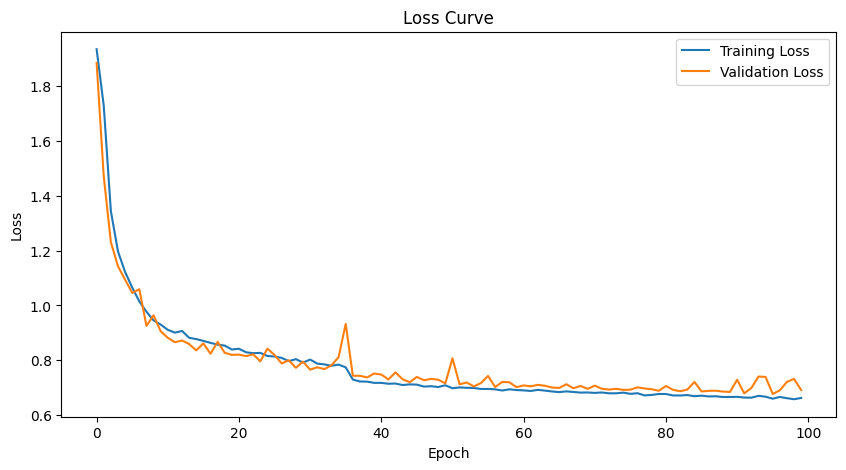

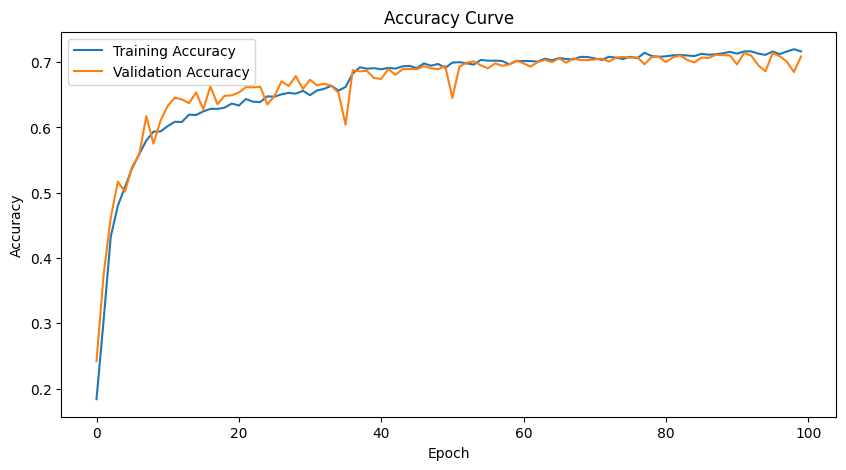

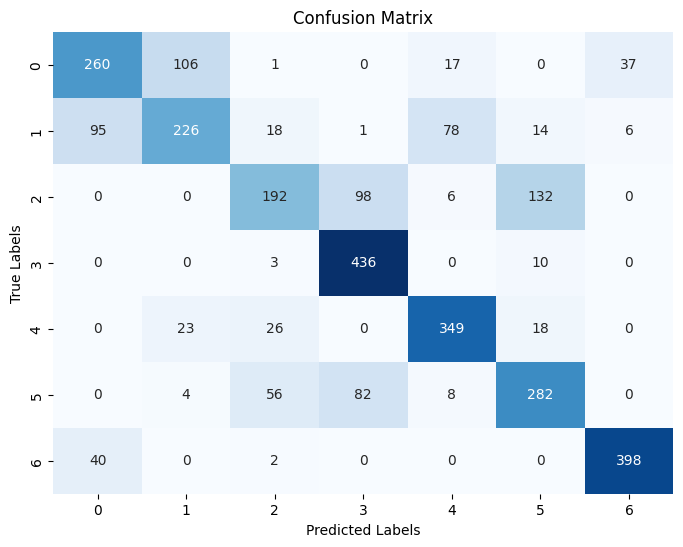

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       421
           1       0.63      0.52      0.57       438
           2       0.64      0.45      0.53       428
           3       0.71      0.97      0.82       449
           4       0.76      0.84      0.80       416
           5       0.62      0.65      0.64       432
           6       0.90      0.90      0.90       440

    accuracy                           0.71      3024
   macro avg       0.70      0.71      0.70      3024
weighted avg       0.70      0.71      0.70      3024



In [9]:
# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(history_nn.history['loss'], label='Training Loss')
plt.plot(history_nn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

# Plot the accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(history_nn.history['accuracy'], label='Training Accuracy')
plt.plot(history_nn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val_nn, predicted_classes_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_val_nn, predicted_classes_nn, zero_division=0))

### Random Forest Model

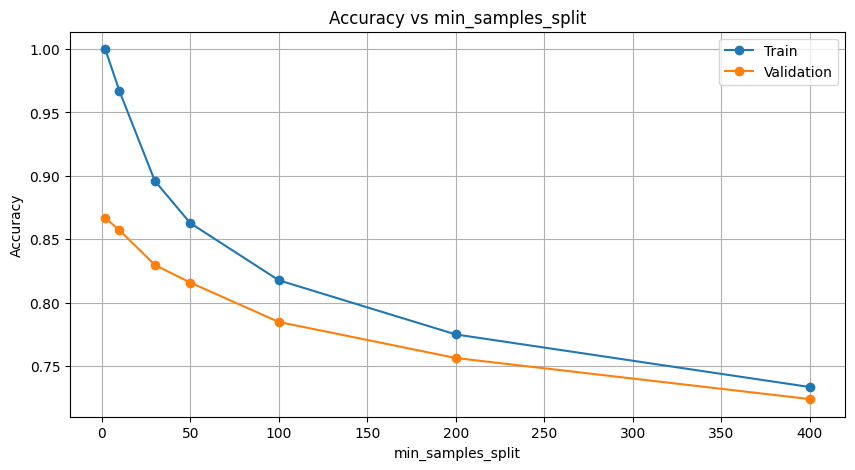

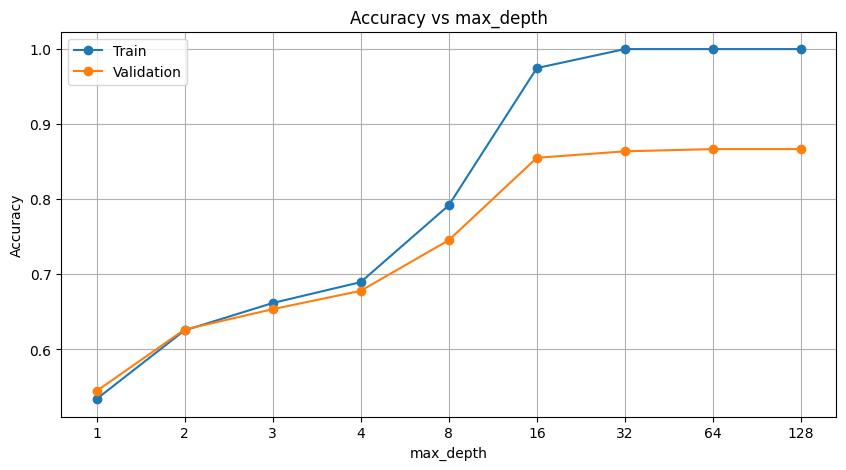

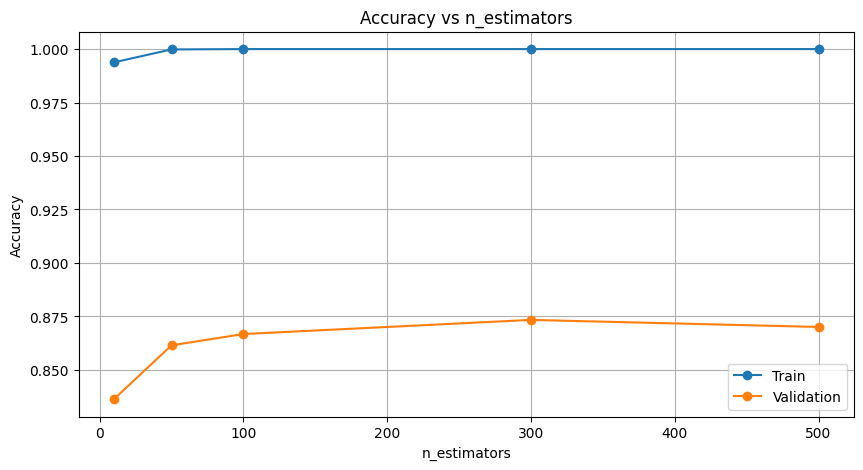

In [10]:
# Extract features (X) and target (y)
X_rf = train_rf.drop('Cover_Type', axis=1).values
y_rf = train_rf['Cover_Type'].values

# Split data into training and validation sets
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Sample split list
samples_split_list = [2, 10, 30, 50, 100, 200, 400]

# Max depth list
max_depth_list = [1, 2, 3, 4, 8, 16, 32, 64, 128]
n_estimators_list = [10, 50, 100, 300, 500]

train_acc_samples = []
val_acc_samples = []

for min_samples_split in samples_split_list:
    rf_model = RandomForestClassifier(min_samples_split=min_samples_split, random_state=60)
    rf_model.fit(X_train_rf, y_train_rf)
    y_train_pred = rf_model.predict(X_train_rf)
    y_val_pred = rf_model.predict(X_val_rf)
    train_acc_samples.append(accuracy_score(y_train_rf, y_train_pred))
    val_acc_samples.append(accuracy_score(y_val_rf, y_val_pred))

plt.figure(figsize=(10, 5))
plt.plot(samples_split_list, train_acc_samples, marker='o')
plt.plot(samples_split_list, val_acc_samples, marker='o')
plt.title('Accuracy vs min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()

# --- Random Forest with varying max_depth ---
train_acc_depth = []
val_acc_depth = []

for max_depth in max_depth_list:
    rf_model = RandomForestClassifier(max_depth=max_depth, random_state=60)
    rf_model.fit(X_train_rf, y_train_rf)
    y_train_pred = rf_model.predict(X_train_rf)
    y_val_pred = rf_model.predict(X_val_rf)
    train_acc_depth.append(accuracy_score(y_train_rf, y_train_pred))
    val_acc_depth.append(accuracy_score(y_val_rf, y_val_pred))

# Replace None with a label
x_labels = [str(d) if d is not None else "None" for d in max_depth_list]

plt.figure(figsize=(10, 5))
plt.plot(x_labels, train_acc_depth, marker='o')
plt.plot(x_labels, val_acc_depth, marker='o')
plt.title('Accuracy vs max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()

train_acc_estimators = []
val_acc_estimators = []

for n in n_estimators_list:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=60)
    rf_model.fit(X_train_rf, y_train_rf)
    y_train_pred = rf_model.predict(X_train_rf)
    y_val_pred = rf_model.predict(X_val_rf)
    train_acc_estimators.append(accuracy_score(y_train_rf, y_train_pred))
    val_acc_estimators.append(accuracy_score(y_val_rf, y_val_pred))

plt.figure(figsize=(10, 5))
plt.plot(n_estimators_list, train_acc_estimators, marker='o')
plt.plot(n_estimators_list, val_acc_estimators, marker='o')
plt.title('Accuracy vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()

Train Accuracy: 0.8997189153439153
Validation Accuracy: 0.8303571428571429
Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.75      0.74       421
           2       0.77      0.64      0.70       438
           3       0.79      0.77      0.78       428
           4       0.90      0.98      0.93       449
           5       0.86      0.93      0.89       416
           6       0.81      0.79      0.80       432
           7       0.93      0.95      0.94       440

    accuracy                           0.83      3024
   macro avg       0.83      0.83      0.83      3024
weighted avg       0.83      0.83      0.83      3024



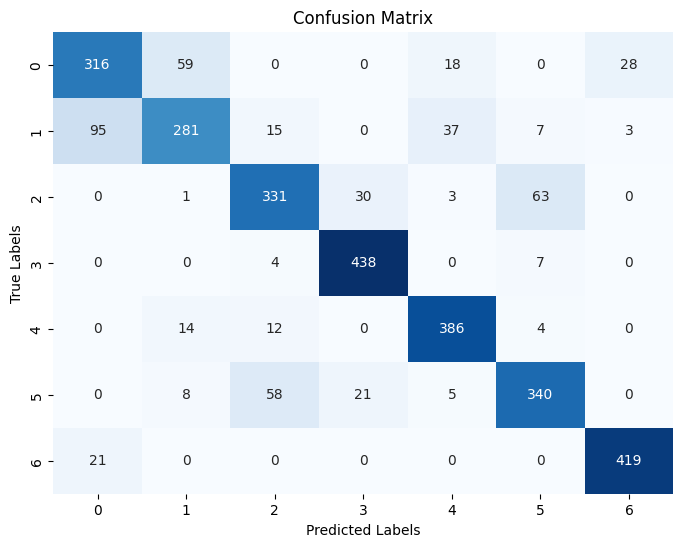

In [11]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(min_samples_split=30, max_depth=32, n_estimators=300, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train_rf)
y_pred_rf = rf_model.predict(X_val_rf)

# Evaluate the model
train_accuracy = accuracy_score(y_train_rf, y_train_pred_rf)
val_accuracy = accuracy_score(y_val_rf, y_pred_rf)
print(f"Train Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

# Generate the classification report
class_report = classification_report(y_val_rf, y_pred_rf)
print("Classification Report:\n", class_report)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_val_rf, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

####  XGBoost

[0]	validation_0-mlogloss:1.44184
[1]	validation_0-mlogloss:1.19912
[2]	validation_0-mlogloss:1.03700
[3]	validation_0-mlogloss:0.92102
[4]	validation_0-mlogloss:0.83700
[5]	validation_0-mlogloss:0.77310
[6]	validation_0-mlogloss:0.72327
[7]	validation_0-mlogloss:0.68364
[8]	validation_0-mlogloss:0.64912
[9]	validation_0-mlogloss:0.62307
[10]	validation_0-mlogloss:0.60194
[11]	validation_0-mlogloss:0.58092
[12]	validation_0-mlogloss:0.56503
[13]	validation_0-mlogloss:0.55314
[14]	validation_0-mlogloss:0.53990
[15]	validation_0-mlogloss:0.52994
[16]	validation_0-mlogloss:0.52119
[17]	validation_0-mlogloss:0.51277
[18]	validation_0-mlogloss:0.50452
[19]	validation_0-mlogloss:0.49700
[20]	validation_0-mlogloss:0.49121
[21]	validation_0-mlogloss:0.48442
[22]	validation_0-mlogloss:0.48066
[23]	validation_0-mlogloss:0.47695
[24]	validation_0-mlogloss:0.47265
[25]	validation_0-mlogloss:0.46750
[26]	validation_0-mlogloss:0.46306
[27]	validation_0-mlogloss:0.45927
[28]	validation_0-mlogloss:0.4

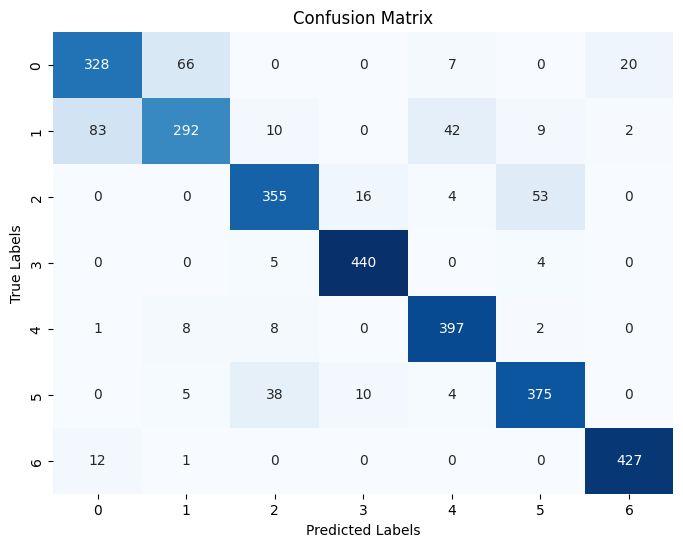

In [12]:
# Extract features (X) and target (y)
X_xgb = train_rf.drop('Cover_Type', axis=1).values
y_xgb = train_rf['Cover_Type'].values - 1 # Adjust labels to be 0-6

# Split data into training and validation sets
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=7, random_state=42, early_stopping_rounds=16)

# Train the model with early stopping
eval_set = [(X_val_xgb, y_val_xgb)]
xgb_model.fit(X_train_xgb, y_train_xgb, eval_set=eval_set, verbose=True)

# Print the best iteration
print(f"Best iteration: {xgb_model.best_iteration}")

# Make predictions
y_pred_xgb = xgb_model.predict(X_val_xgb)

# Evaluate the model
accuracy = accuracy_score(y_val_xgb, y_pred_xgb)
print(f"Accuracy: {accuracy}")

# Generate the classification report
class_report = classification_report(y_val_xgb, y_pred_xgb)
print("Classification Report:\n", class_report)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_val_xgb, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()